# LioNets: Turbofan Engine Degradation Simulation Dataset with Neural Networks -> Classification Task

In this notebook, we present how LioNets can be applied in predictive models using time series data.

In [1]:
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
%matplotlib inline
from IPython.display import Image
from IPython.display import SVG
from IPython.display import display                               
from ipywidgets import interactive, BoundedFloatText, FloatSlider, IntSlider, \
    RadioButtons, IntRangeSlider, Dropdown, jslink, jsdlink, interactive_output, HBox, VBox
from load_dataset import Load_Dataset
import matplotlib.pyplot as plt
from collections import OrderedDict
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
from math import sqrt, exp, log
from sklearn.linear_model import Lasso, Ridge, RidgeCV, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, balanced_accuracy_score, accuracy_score
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, TimeDistributed, RepeatVector,Flatten, \
    Input, Dropout, LSTM, concatenate, Reshape, Conv1D, GlobalMaxPool1D
import keras.backend as K
from keras.utils import plot_model
from LioNets import LioNet

Using TensorFlow backend.


First of all, we load and clean our data.

In [3]:
fm, feature_names = Load_Dataset.load_data_turbofan(False)

fm1_train = fm['FaultMode1']['df_train']
fm1_train_target = fm1_train['RUL'].values
fm1_test= fm['FaultMode1']['df_test']
fm1_test_target = fm1_test['RUL'].values

We are dropping some unecessary features.

In [4]:
LSTM_train = fm1_train.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])
LSTM_test = fm1_test.drop(columns=['t', 'os_1', 'os_2', 'os_3', 's_01', 's_05', 's_06', 's_10', 's_16', 's_18', 's_19', 's_22', 's_23', 's_24', 's_25', 's_26'])

We collect the different units, in order to the next steps to create time windows

In [5]:
train_units = set(LSTM_train['u'].values)
test_units = set(LSTM_test['u'].values)

We are scaling our data per feature

In [6]:
sensors = ['s_02', 's_03', 's_04', 's_07', 's_08', 's_09', 's_11', 's_12',
            's_13', 's_14', 's_15', 's_17', 's_20', 's_21']
scalers = {}
for column in sensors:
    scaler = MinMaxScaler(feature_range=(0.1,1.1))
    LSTM_train[column] = scaler.fit_transform(LSTM_train[column].values.reshape(-1,1))
    LSTM_test[column] = scaler.transform(LSTM_test[column].values.reshape(-1,1))
    scalers[column] = scaler

We create time windows with a specific size. In this example, we create time windows of 50 timesteps.

In [7]:
unit_scalers = {}
window = 50
temp_LSTM_x_train = []
LSTM_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_train[LSTM_train['u']==unit]['RUL'].values
    
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_train.append(np.array(temp_instance))
        LSTM_y_train.append(temp_unit_RUL[i+window-1])
LSTM_y_train = np.array(LSTM_y_train)
LSTM_x_train = np.array(temp_LSTM_x_train)

temp_LSTM_x_test = []
LSTM_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
    temp_unit_RUL = LSTM_test[LSTM_test['u']==unit]['RUL'].values
        
    for i in range(len(temp_unit) - window + 1):#elekse edw an len temp_unit - window > 0
        temp_instance = []
        for j in range(window):
            temp_instance.append(temp_unit[i+j])
        temp_LSTM_x_test.append(np.array(temp_instance))
        LSTM_y_test.append(temp_unit_RUL[i+window-1])
LSTM_y_test = np.array(LSTM_y_test)
LSTM_x_test = np.array(temp_LSTM_x_test)

We can check how many train, test instances we have. These are changing regarding the time window size.

In [8]:
LSTM_x_train.shape, LSTM_x_test.shape, LSTM_y_train.shape, LSTM_y_test.shape

((15731, 50, 14), (8255, 50, 14), (15731,), (8255,))

Now we need to transform our RUL to binary classes. 0 Would mean that no maintenance is needed, because the prediction had a high RUL value. 1 would mean that the RUL is low and you may need maintenance on your component! You can try different time frames as well.

In [9]:
time_frame = 30

In [10]:
temp_LSTM_y_train = np.array([1 if i <= time_frame else 0 for i in LSTM_y_train])
temp_LSTM_y_test = np.array([1 if i <= time_frame else 0 for i in LSTM_y_test])

We need a rmse loss function too! for the decoder

In [11]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

Now, we can build our predictor

In [12]:
feature_names = fm1_train.columns
encoder_input = Input(shape=(LSTM_x_train[0].shape))

encoder_x = LSTM(units=80, return_sequences=True, activation='tanh')(encoder_input)
encoder_x = Dropout(0.5)(encoder_x)
encoder_x = LSTM(units=40, return_sequences=False, activation='tanh')(encoder_x)

encoder_y = Conv1D(filters=40,kernel_size=3,activation='tanh')(encoder_input)
encoder_y = GlobalMaxPool1D()(encoder_y)

encoded = concatenate([encoder_x,encoder_y])
encoded = Dropout(0.5)(encoded)
encoded = Dense(80, activation='tanh')(encoded)#Relu and selu
encoded = Dropout(0.5)(encoded)
encoded = Dense(40, activation='tanh')(encoded)#Relu and selu
predictions = Dense(1, activation='sigmoid')(encoded)#Relu and selu
predictor = Model(encoder_input,predictions)

predictor.compile(optimizer="adam",loss=['binary_crossentropy'],metrics=['accuracy'])
#print(predictor.summary())

checkpoint_name = 'TEDS_Predictor_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Then, we train the predictor.

In [13]:
#predictor.fit(LSTM_x_train, temp_LSTM_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.33, verbose=2, callbacks=[checkpoint])

We load our weights, and we measure the performance.

In [14]:
wights_file = 'TEDS_Predictor_Classification.hdf5' # choose the best checkpoint few features
predictor.load_weights(wights_file) # load it
predictor.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [15]:
temp_pred = predictor.predict(LSTM_x_train)

In [16]:
temp_pred = predictor.predict(LSTM_x_train)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Train:',f1_score(temp_LSTM_y_train,predictions, average='micro'),f1_score(temp_LSTM_y_train,predictions, average='weighted'),balanced_accuracy_score(temp_LSTM_y_train,predictions),accuracy_score(temp_LSTM_y_train,predictions))

temp_pred = predictor.predict(LSTM_x_test)
predictions = [0 if i[0] <=0.5 else 1 for i in temp_pred]
print('Test:',f1_score(temp_LSTM_y_test,predictions, average='micro'),f1_score(temp_LSTM_y_test,predictions, average='weighted'),balanced_accuracy_score(temp_LSTM_y_test,predictions),accuracy_score(temp_LSTM_y_test,predictions))

Train: 0.9758438751509758 0.9756563803680429 0.9542879398101445 0.9758438751509758
Test: 0.9855844942459115 0.9845923721401666 0.8467556329064839 0.9855844942459115


Then, we have to extract the encoder from our predictor.

In [17]:
encoder = Model(input=predictor.input, output=[predictor.layers[-2].output])
encoder.trainable = False
encoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#encoder.summary()

Now we are ready to extract for all instances, their encoded representation

In [18]:
encoded_LSTM_x_train = encoder.predict(LSTM_x_train)
encoded_LSTM_x_test = encoder.predict(LSTM_x_test)

And by that, we build the decoder.

In [19]:
encoded_input = Input(shape=(encoded_LSTM_x_train[0].shape))
decoded = Dense(120, activation='tanh')(encoded_input)
decoded = Dropout(0.5)(decoded)

decoded_y = RepeatVector(54)(decoded)
decoded_y = Conv1D(filters=50,kernel_size=5,activation='tanh')(decoded_y)

decoded_x = RepeatVector(50)(decoded)
decoded_x = LSTM(units=80, return_sequences=True, activation='tanh')(decoded_x)
decoded_x = Dropout(0.5)(decoded_x)
decoded_x = LSTM(units=50, return_sequences=True, activation='tanh')(decoded_x)

decoded = concatenate([decoded_x,decoded_y])
decoded = Dense(50, activation='sigmoid')(decoded)
decoded = Dropout(0.5)(decoded)
decoded = Dense(14, activation='sigmoid')(decoded)

decoder = Model(encoded_input,decoded)

decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])
#print(decoder.summary())

checkpoint_name = 'TEDS_Decoder_Classification.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [20]:
#decoder.fit(encoded_LSTM_x_train, LSTM_x_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.33, verbose=2, callbacks=[checkpoint])

In [21]:
wights_file = 'TEDS_Decoder_Classification.hdf5' # choose the best checkpoint few features
decoder.load_weights(wights_file) # load it
decoder.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [22]:
decoder.evaluate(encoded_LSTM_x_train,LSTM_x_train)

15731/15731 [==============================] - 5s 314us/step


[0.06820674527842154, 0.05212166352636459, 0.004656450237194814]

In [23]:
decoder.evaluate(encoded_LSTM_x_test,LSTM_x_test)

8255/8255 [==============================] - 3s 313us/step


[0.06830550037067201, 0.05229725340490699, 0.0046694804804296944]

---
## Forecaster

In [24]:
window = 50
forecast_timesteps = 5

temp_fc_x_train = []
temp_fc_y_train = []
for unit in train_units:
    temp_unit = LSTM_train[LSTM_train['u']==unit].drop(columns=['u','RUL']).values
   
    for i in range(len(temp_unit) - window - forecast_timesteps + 1):#elekse edw an len temp_unit - window > 0
        temp_instance_x = []
        temp_instance_y = []
        for j in range(window):
            temp_instance_x.append(temp_unit[i+j])
        for z in range(forecast_timesteps):
            temp_instance_y.append(temp_unit[i+j+z+1])            
        temp_fc_x_train.append(np.array(temp_instance_x))
        temp_fc_y_train.append(np.array(temp_instance_y))       
fc_x_train = np.array(temp_fc_x_train)
fc_y_train = np.array(temp_fc_y_train)

temp_fc_x_test = []
temp_fc_y_test = []
for unit in test_units:
    temp_unit = LSTM_test[LSTM_test['u']==unit].drop(columns=['u','RUL']).values
        
    for i in range(len(temp_unit) - window - forecast_timesteps + 1):#elekse edw an len temp_unit - window > 0
        temp_instance_x = []
        temp_instance_y = []
        for j in range(window):
            temp_instance_x.append(temp_unit[i+j])
        for z in range(forecast_timesteps):
            temp_instance_y.append(temp_unit[i+j+z+1])            
        temp_fc_x_test.append(np.array(temp_instance_x))
        temp_fc_y_test.append(np.array(temp_instance_y))       
fc_x_test = np.array(temp_fc_x_test)
fc_y_test = np.array(temp_fc_y_test)

In [25]:
fc_x_train.shape, fc_x_test.shape, fc_y_train.shape, fc_y_test.shape

((15231, 50, 14), (7794, 50, 14), (15231, 5, 14), (7794, 5, 14))

In [26]:
forecast_input = Input(shape=(LSTM_x_train[0].shape))

forecast_x = LSTM(units=240, return_sequences=True, activation='tanh')(forecast_input)
forecast_x = Dropout(0.5)(forecast_x)
forecast_x = LSTM(units=120, return_sequences=False, activation='tanh')(forecast_x)

forecast_y = Conv1D(filters=120,kernel_size=3,activation='tanh')(forecast_input)
forecast_y = GlobalMaxPool1D()(forecast_y)

forecast = concatenate([forecast_y,forecast_x])
forecast = RepeatVector(5)(forecast)
forecast = Dropout(0.5)(forecast)
forecast = Dense(120, activation='tanh')(forecast)#Relu and selu
forecast = Dropout(0.5)(forecast)
forecast = Dense(60, activation='tanh')(forecast)#Relu and selu
predictions = Dense(14, activation='sigmoid')(forecast)#Relu and selu
forecaster = Model(forecast_input,predictions)

forecaster.compile(optimizer="adam", loss=[root_mean_squared_error],metrics=['mae','mse'])

checkpoint_name = 'TEDS_Forecaster_Classification_Matrix.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 2, save_best_only = True, mode ='auto')

In [27]:
#forecaster.fit(fc_x_train, fc_y_train, epochs=250, batch_size=512, shuffle=True, validation_split=0.3, verbose=2, callbacks=[checkpoint])

In [28]:
weights_file = 'TEDS_Forecaster_Classification_Matrix.hdf5' # choose the best checkpoint few features
forecaster.load_weights(weights_file) # load it
forecaster.compile(optimizer="adam",loss=[root_mean_squared_error],metrics=['mae','mse'])

In [29]:
predictions = forecaster.predict(fc_x_train)
print('Train:',mean_absolute_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_train.reshape(-1,70),predictions.reshape(-1,70))))
print(r2_score(fc_y_train.reshape(-1,70),predictions.reshape(-1,70)))

Train: 0.05088091525305008 0.00455687659597555 0.06750464129210339
0.7545744057481202


In [30]:
predictions = forecaster.predict(fc_x_test)
print('Test:',mean_absolute_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)),sqrt(mean_squared_error(fc_y_test.reshape(-1,70),predictions.reshape(-1,70))))
print(r2_score(fc_y_test.reshape(-1,70),predictions.reshape(-1,70)))

Test: 0.05075032618551064 0.004543088422608085 0.06740243632546293
0.6147436201423792


---
## LioNets Experiments
Having everything setted up, we are now ready to try our methodology. We first initialize LioNets. LioNets requires a predictor (the classifier itself), an encoder (extracted from the predictor), a decoder, as well as some data (for best results the training data, in order to push the neighbourhood generation through known distribution for the network)

In [31]:
lionet = LioNet(predictor, decoder, encoder, LSTM_x_train)

Then we would like to manually evaluate an instance

In [32]:
temp_instance = LSTM_x_train[112].copy()
model = Ridge(alpha=0.0001,fit_intercept=True,random_state=0)
weights, real_prediction, local_prediction = lionet.explain_instance(temp_instance,200,model)
weights = weights * temp_instance.reshape(700)

In [33]:
"Real prediction: " + str(real_prediction)[:7] + ", Local prediction: " + str(local_prediction)[:7]

'Real prediction: 0.59149, Local prediction: 0.59149'

What we would like is to change the class. Currently, the classifier for the predictor is closer to the maintenance class. So we need to see which measurements are pussing the prediction towards this class

From LioNets we acquired the weights of each sensor's measurements. Then we extract some statistics

In [34]:
sensors_all = {}
count = 0
for j in range(50):
    count2 = 0
    for i in sensors:
        sensors_all.setdefault(i,[]).append([j, weights[count+count2], temp_instance[j][count2],
                                             weights[count+count2]*temp_instance[j][count2]])
        count2 = count2 + 1
    count = count + 14
sensors_std = []
sensors_mean = []
sensors_max = []
sensors_min = []
for i in sensors_all:
    naa = np.array(sensors_all[i])[:,3]
    sensors_std.append(naa.std())
    sensors_mean.append(naa.mean())
    sensors_max.append(naa.max())
    sensors_min.append(naa.min())

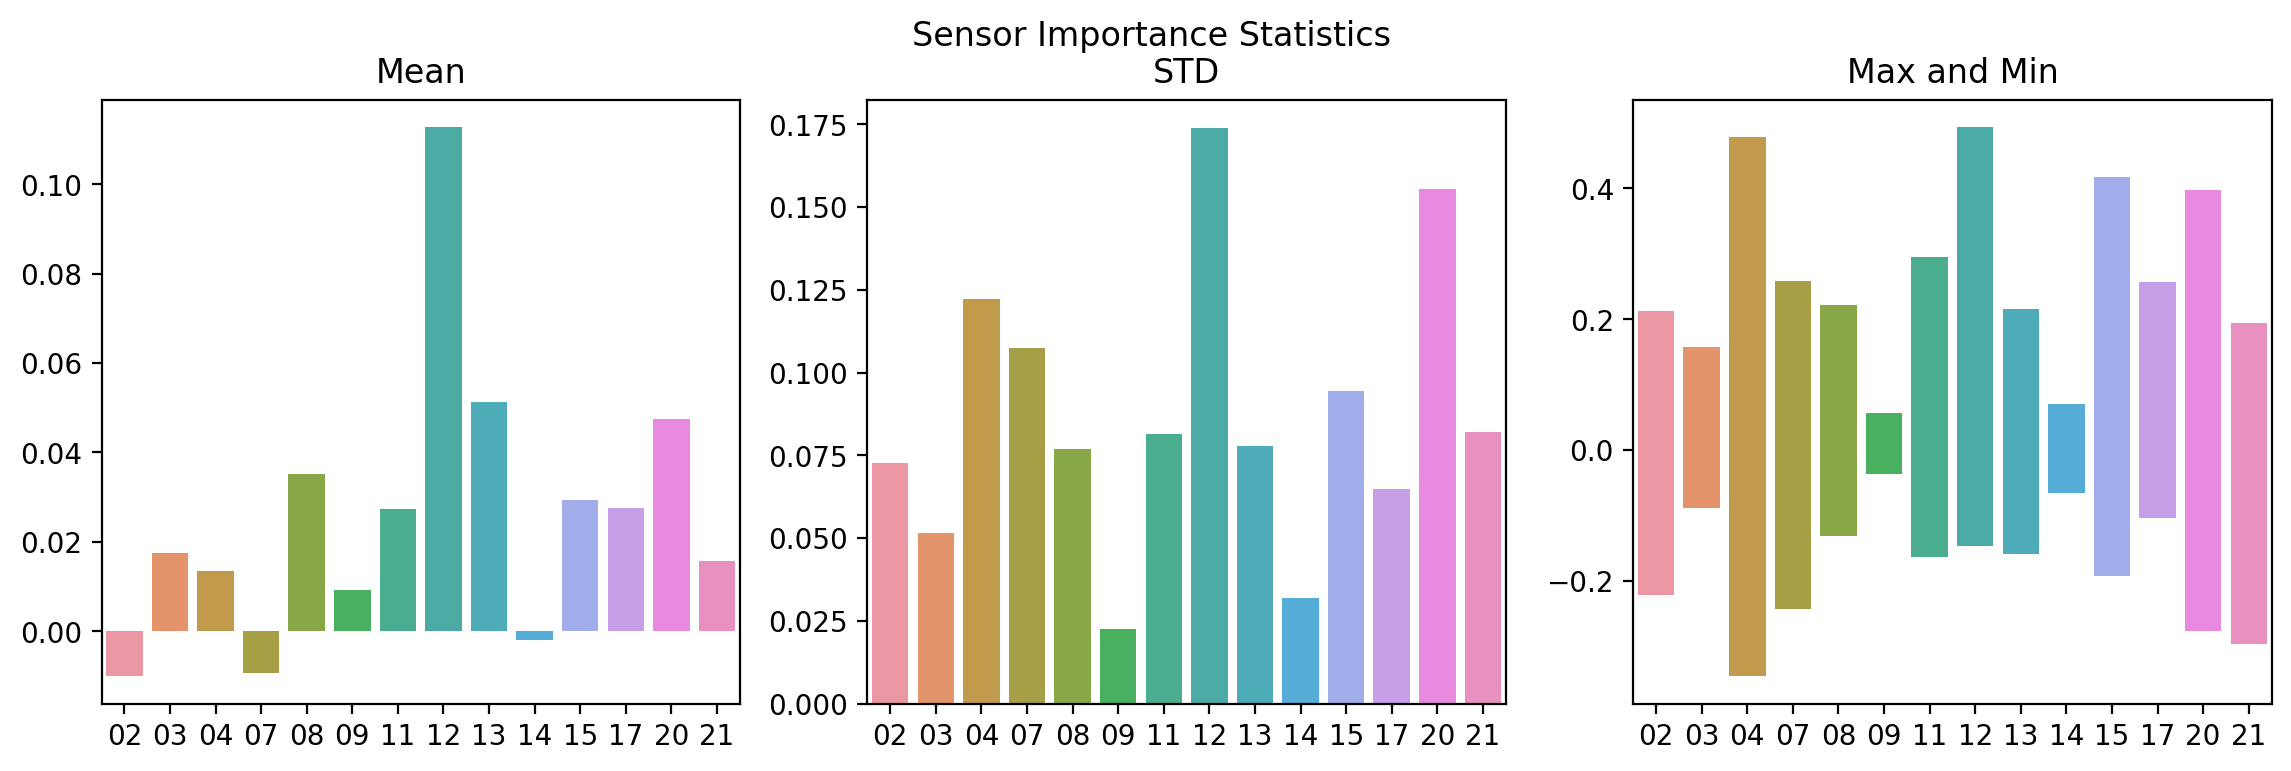

interactive(children=(IntSlider(value=1, description='sens_i', max=14, min=1), Output()), _dom_classes=('widge…

In [35]:
to_vis = [i[2:] for i in sensors]
fig, axs = plt.subplots(1, 3, figsize=(14, 4), dpi=200)
sns.barplot(to_vis,sensors_mean,ax=axs[0])
axs[0].set_title('Mean')
sns.barplot(to_vis,sensors_std,ax=axs[1])
axs[1].set_title('STD')
sns.barplot(to_vis,sensors_max,ax=axs[2])
sns.barplot(to_vis,sensors_min,ax=axs[2])
axs[2].set_title('Max and Min')
fig.suptitle('Sensor Importance Statistics')
plt.show()

def plot_sensor(sens_i=1):
    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,1])
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    sns.lineplot(np.array(sensors_all['s_02'])[:,0],np.array(sensors_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(sensors_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
inter=interactive(plot_sensor 
   , sens_i=(1,14))
display(inter)

Find the sensors with the most negative and positive influence based on the mean of time-step feature weights.

Data statistics -> (Global Mean & STD per sensor) 

In [36]:
temp_train = LSTM_x_train.reshape(-1,14)
global_mean, global_std = [],[]
for i in range(14):
    global_mean.append(temp_train[:,i].mean())
    global_std.append(temp_train[:,i].std())

Make modifications to the measurements of a seleced sensor.

In [202]:
def modify(temp_instance, sens, mod, uni_sldr=0, rd_btn=1, rng_sldr=(1,50)):
    
    start, end = rng_sldr[0], rng_sldr[1]
    
    mod_instance = temp_instance.copy()
    local_mean = temp_instance[start-1:end,sens].mean()
      
    # ---MODS---        
    if mod == 1: # Uniform
        for i in range(start-1, end):
            if weights.reshape(50,14)[i,sens] > 0 and rd_btn > 0:
                mod_instance[i,sens] = mod_instance[i,sens] + uni_sldr
            if weights.reshape(50,14)[i,sens] < 0 and rd_btn < 0:
                mod_instance[i,sens] = mod_instance[i,sens] + uni_sldr    
    elif mod == 2: # Local MEan
        mod_instance[start-1:end, sens] = local_mean    
    elif mod == 3: # Global Mean 
        mod_instance[start-1:end, sens] = global_mean[sens]   
    elif mod == 4: # Zeros
        mod_instance[start-1:end, sens] = 0.1    
    elif mod == 5: # Gaussian Noise
        for i in range(start-1, end):
            np.random.seed(2000+i)
            gaussian_noise = np.random.normal(global_mean[sens], global_std[sens], 1)/10
            mod_instance[i,sens] += gaussian_noise[0]
        np.clip(mod_instance,0.1,1.1,out=mod_instance)    
    elif mod == 6: # Neural Forecaster
        prediction = forecaster.predict(np.expand_dims(temp_instance,axis=0))
        prediction = prediction.reshape(5,14)
        mod_instance = np.append(temp_instance,prediction,axis=0)
        mod_instance = mod_instance[5:]
    elif mod == 7: # Static Forecaster
        for i in range(mod_instance.shape[1]):
            dif = mod_instance[-1,i] - mod_instance[-6:-1,i]
            temp = np.flip(dif) + mod_instance[-1,i]
            #temp = np.array([dif*(e+1) for e,i in enumerate(range(5))]) + mod_instance[-1,i]
            mod_instance[:,i] = np.append(mod_instance[5:,i],temp)  
            np.clip(mod_instance[:,i],0.1,1.1,out=mod_instance[:,i])
        
    return mod_instance

In [186]:
def moded_instance_statistics(instance):
    
    model = Ridge(alpha=0.0001,fit_intercept=True,random_state=0)
    weights, real_prediction, local_prediction = lionet.explain_instance(instance,200,model)
    weights = weights * instance.reshape(700)

    sensors_all = {}
    count = 0
    for j in range(50):
        count2 = 0
        for i in sensors:
            sensors_all.setdefault(i,[]).append([j, weights[count+count2], instance[j][count2],
                                                 weights[count+count2]*instance[j][count2]])
            count2 = count2 + 1
        count = count + 14
    sensors_std = []
    sensors_mean = []
    sensors_max = []
    sensors_min = []
    for i in sensors_all:
        naa = np.array(sensors_all[i])[:,3]
        sensors_std.append(naa.std())
        sensors_mean.append(naa.mean())
        sensors_max.append(naa.max())
        sensors_min.append(naa.min())
    return [real_prediction, local_prediction], sensors_all, [sensors_mean,sensors_std,sensors_min,sensors_max]

Find 2 sensors with the most negative and positive influence based on the mean of time-step feature weights.

Then recommend certain modifications that can be applied on their measurements that lead to a change in the RUL propability estimation.

In [204]:
def recommend_modifications(sensors_mean):
    
    indexed = list(enumerate(sensors_mean))
    indexed.sort(key=lambda tup: tup[1])
    cls0_sens = list([i for i, v in indexed[:2]])
    cls1_sens = list(reversed([i for i, v in indexed[-2:]]))
#     print("Class 0 important sensors:",sensors[cls0_sens[0]], sensors[cls0_sens[1]])
#     print("Class 1 important sensors:",sensors[cls1_sens[0]], sensors[cls1_sens[1]])

    mods = ['Original', 'Uniform', 'Mean(Local)', 'Mean(Global)', 'Zero', 'Noise', 'Forecast(Neural)', 'Forecast(Static)']
    weights = ['Negative Weights', 'Positive Weights']
    
    cls0_mod_results = []
    cls1_mod_results = []
    unif_tests= [0.1, 0.5, -0.1, -0.5]
    
    for sens in cls0_sens:
        temp = []
        for v,w in zip(unif_tests,np.sign(unif_tests)):
            mod_inst = modify(temp_instance, sens, 1, v, w)
            mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(mod_inst)
            temp.append((mod_preds[1],sens,1,v,w))
        for mod in range(2,len(mods)):
            mod_inst = modify(temp_instance, sens, mod)
            mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(mod_inst)
            temp.append((mod_preds[1],sens,mod))
        cls0_mod_results.append(max(temp))

    for sens in cls1_sens:
        temp = []
        for v,w in zip(unif_tests,-np.sign(unif_tests)):
            mod_inst = modify(temp_instance, sens, 1, v, w)
            mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(mod_inst)
            temp.append((mod_preds[1],sens,1,v,w))
        for mod in range(2,len(mods)):
            mod_inst = modify(temp_instance, sens, mod)
            mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(mod_inst)
            temp.append((mod_preds[1],sens,mod))
        cls1_mod_results.append(min(temp))


    recommendation = "\n\t\t\t\t\t\t<<< Recommendations >>>\n\n"
    for rec in cls0_mod_results:
        if rec[2]==1:
            recommendation += "Try the Uniform modification on sensor "+str(sensors[rec[1]])+" with Value: "+str(rec[3])+ \
            " on the "+str(weights[int((1+rec[4])/2)])+" to increase the RUL propability.\n"
        else:
            recommendation += "Try the "+str(mods[rec[2]])+" modification on sensor "+str(sensors[rec[1]])+ \
            " to increase the RUL propability.\n"
    
    recommendation += "\n"        
    for rec in cls1_mod_results:
        if rec[2]==1:
            recommendation += "Try the Uniform modification on sensor "+str(sensors[rec[1]])+" with Value: "+str(rec[3])+ \
            " on the "+str(weights[int((1+rec[4])/2)])+" to decrease the RUL propability.\n"
        else:
            recommendation += "Try the "+str(mods[rec[2]])+" modification on sensor "+str(sensors[rec[1]])+ \
            " to decrease the RUL propability.\n"
    
    return recommendation
    

Plot the new modified instances and inspect the changes of the predictions. 

In [205]:
rangeSlider, modification, sens_i_Mod, uniSlider, radioBtn = (-1,-1), -1, -1, -1, -1

# Recommend modifications
recommendation = recommend_modifications(sensors_mean)
print(recommendation)

original_preds, original_sens_all, original_sens_stats = moded_instance_statistics(temp_instance)

def plot_sensor(sens_i, mod_sens_i, mod, rng_sldr, uni_sldr, rd_btn):

    global rangeSlider, modification, sens_i_Mod, uniSlider, radioBtn, mod_preds, mod_sens_all, mod_sens_stats
    
    uniform_slider.disabled, radio_button.disabled, modify_sens_i.disabled, range_slider.disabled = True, True, False, False
    if mod==1:
        uniform_slider.disabled, radio_button.disabled = False, False
    if mod==0 or mod==6 or mod==7:
        modify_sens_i.disabled, range_slider.disabled = True, True
            
    if modification!=mod or rangeSlider!=rng_sldr or sens_i_Mod!=mod_sens_i or uniSlider!=uni_sldr or radioBtn!=rd_btn:
        inst_mod = modify(temp_instance, mod_sens_i-1, mod, uni_sldr, rd_btn, rng_sldr)
        rangeSlider, modification, sens_i_Mod, uniSlider, radioBtn = rng_sldr, mod, mod_sens_i, uni_sldr, rd_btn 
        mod_preds, mod_sens_all, mod_sens_stats = moded_instance_statistics(inst_mod)
        
    print("ORIGINAL -> Real prediction: " + str(original_preds[0])[:7] + ", Local prediction: " + str(original_preds[1])[:7])
    print()
    print("  MOD    -> Real prediction: " + str(mod_preds[0])[:7] + ", Local prediction: " + str(mod_preds[1])[:7])
    
    #Plot the figures 
    to_vis = [i[2:] for i in sensors]
    x = np.arange(len(to_vis))
    width = 0.4
    
    fig, axs = plt.subplots(1, 3, figsize=(18, 4), dpi=200)
    axs[0].bar(x-width, original_sens_stats[0], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[0].bar(x, mod_sens_stats[0], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[0].set_title('Mean')
    axs[0].legend(('Οriginal','Modded'))
    axs[1].bar(x-width, original_sens_stats[1], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[1].bar(x, mod_sens_stats[1], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[1].set_title('STD')
    axs[2].bar(x-width, original_sens_stats[2], width=width, tick_label=to_vis, align='edge', color='C0',)
    axs[2].bar(x-width, original_sens_stats[3], width=width, tick_label=to_vis, align='edge', color='C0')
    axs[2].bar(x, mod_sens_stats[2], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[2].bar(x, mod_sens_stats[3], width=width, tick_label=to_vis, align='edge', color='C1')
    axs[2].set_title('Max and Min')  
#     for i in rec_sens:
#         org_means[i].set_ecolor('r')
    
    fig.suptitle('Sensor Importance Statistics')
    plt.show()

    plt.figure(figsize=(14, 4), dpi=200, facecolor='w', edgecolor='k')
    plt.subplot(131)
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(original_sens_all[sensors[sens_i-1]])[:,1],color='grey',linestyle = ':')
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(mod_sens_all[sensors[sens_i-1]])[:,1],color='tab:blue')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,1].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence"))
    plt.subplot(132)
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(original_sens_all[sensors[sens_i-1]])[:,2],color='grey',linestyle = ':')
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(mod_sens_all[sensors[sens_i-1]])[:,2],color='g')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,2].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " value"))
    plt.subplot(133)
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(original_sens_all[sensors[sens_i-1]])[:,3],color='grey',linestyle = ':')
    plt.plot(np.array(mod_sens_all['s_02'])[:,0],np.array(mod_sens_all[sensors[sens_i-1]])[:,3],color='r')
    plt.hlines(y=np.array(mod_sens_all[sensors[sens_i-1]])[:,3].mean(), xmin=0, xmax=50, label='mean')
    plt.title(str("Sensor\'s " + sensors[sens_i-1] + " influence * value"))
    plt.show()
    
### Set the interactive UI ###

range_slider = IntRangeSlider(value=[1,50], min=1, max=50, description="Range: ", continuous_update = False)
view_sens_i = IntSlider(min=1, max=14, default_value=2, description="View Sensor: ", continuous_update = False)
modify_sens_i = IntSlider(min=1, max=14, default_value=2, description="Mod Sensor: ", continuous_update = False)
uniform_slider = FloatSlider(value=0, min=-1.1, max=1.1, step=0.05, description='Value:', continuous_update = False)
radio_button = RadioButtons(options=[('Positive Weights', 1), ('Negative Weights', -1)], description='Affect:')
mod = Dropdown(options=[('Original', 0), ('Uniform', 1), ('Mean (Local)', 2), ('Mean (Global)', 3),
                        ('Zero', 4), ('Noise', 5), ('Forecast (Neural)', 6), ('Forecast (Static)', 7)], description="Mods: ")
jsdlink((modify_sens_i, 'value'), (view_sens_i, 'value'))

ui = HBox([VBox([modify_sens_i,view_sens_i]), VBox([mod, range_slider]), VBox([uniform_slider, radio_button])])
inter = interactive_output(plot_sensor, {'sens_i':view_sens_i, 'mod_sens_i':modify_sens_i, 'mod':mod, 'rng_sldr':range_slider, 
                                         'uni_sldr':uniform_slider, 'rd_btn':radio_button})
display(ui,inter)


						<<< Recommendations >>>

Try the Forecast(Static) modification on sensor s_02 to increase the RUL propability.
Try the Forecast(Static) modification on sensor s_07 to increase the RUL propability.

Try the Uniform modification on sensor s_12 with Value: 0.5 on the Negative Weights to decrease the RUL propability.
Try the Uniform modification on sensor s_13 with Value: -0.5 on the Positive Weights to decrease the RUL propability.



Output()